# Assignment 3 - Numerical Integrators


**General instructions**

For this assignment, you will investigate the error behaviour of numerical integration methods. You will analyze the error behaviour for the dynamics of the JUICE spacecraft during two phases, namely:

* During the flyby of Callisto, total propagation time 8 hours. The initial time for the flyby must be retrieved from the `assignment3Input-2020-2021.txt` file for your specific student number. Use the data in this file to set the `flyby_initial_time` variable in the first code block.
* During a 24-hour period of the Ganymede circular orbit phase. See assignment 1 for the initial time you are to use,  which you should defined in `orbit_initial_time` variable in the first code block. This phase will be denoted as GCO500 from hereon, total propagation time 24 hours.


In your report, your discussion should be backed by figures showing your numerical results. You are to decide which figures you deem necessary to back up your conclusions, in addition to any specific requirements given for figures.

All analysis on the output data can be done in the notebook. However, if you would like to use a different piece of software (e.g. Matlab) for your analyses, the relevant data is provided as output to data filesAll analysis on the output data can be done in the notebook. However, if you would like to use a different piece of software (e.g. Matlab) for your analyses, the relevant data is provided as output to data files by calling:

* The `write_propagation_results_and_analytical_solution_to_file` function: this is used when propagating without perturbations. This functions writes the unperturbed numerical solution to a file, and computes the difference of the numerical solution w.r.t. the analytical solution, and writes this difference to a file.
* The `write_propagation_results_and_benchmark_difference_to_file` function: this is used when propagating with or without perturbations. This functions writes the numerical solution to a file, and computes the difference of this solution w.r.t. the numerical benchmark solution, and writes this difference to a file

**Before starting the assignment, read the submission instructions given at the end of this notebook.**

In [2]:
''' 
Copyright (c) 2010-2020, Delft University of Technology
All rigths reserved

This file is part of the Tudat. Redistribution and use in source and 
binary forms, with or without modification, are permitted exclusively
under the terms of the Modified BSD license. You should have received
a copy of the license with this file. If not, please or visit:
http://tudat.tudelft.nl/LICENSE.
'''

import numpy as np
from tudatpy import elements
from tudatpy.io import save2txt
from tudatpy.kernel import constants
from tudatpy.kernel.astro import conversion
from tudatpy.kernel.astro import two_body_dynamics
from tudatpy.kernel.interface import spice_interface
from tudatpy.kernel.math import interpolators
from tudatpy.kernel.simulation import environment_setup
from tudatpy.kernel.simulation import propagation_setup
from matplotlib import pyplot as plt
import matplotlib

# STUDENT Code task (fill in value from  assignment3Input-2020-2021.txt file provided through Brightspace)
flyby_initial_time = 978095247.277556

# STUDENT Code task (fill in student number, 1244779 --> 1244ABC)
A = 3
B = 1
C = 8
orbit_initial_time = 33.15 * constants.JULIAN_YEAR + A * 7.0 * constants.JULIAN_DAY + \
                            B * constants.JULIAN_DAY + C * constants.JULIAN_DAY / 24.0

# Load spice kernels.
spice_interface.load_standard_kernels()

# Set output directory
output_directory = "./SimulationOutput/"

# Define global settings
bodies_to_integrate = ["JUICE"]
central_bodies_per_phase = [ "Callisto", "Ganymede" ]
initial_times_per_phase = [ flyby_initial_time, orbit_initial_time ]
propagation_times_per_phase = [ 8.0 * 3600.0, 24.0 * 3600.0 ]

global_frame_origin = "Jupiter"
global_frame_orientation = "ECLIPJ2000"


# Helper Functions (DO NOT MODIFY)

In [3]:
# Function to retrieve the difference of a numerical state history w.r.t. a Keplerian orbit
# The Keplerian orbit w.r.t. which the difference is computed is based on the first time-entry
# in the state history.
def get_difference_wrt_kepler_orbit( state_history, central_body_gravitational_parameter ):
    
    # Retrieve initial Kepler elements and time
    initial_keplerian_elements = conversion.cartesian_to_keplerian( 
        list(state_history.values())[0], central_body_gravitational_parameter )
    initial_time = list( state_history.keys() )[0]
    
    keplerian_solution_difference = dict()
    for epoch in state_history.keys():
        
        # Compute Keplerian state at current epoch (e.g. propagate mean anomaly to current time)
        propagated_kepler_state = two_body_dynamics.propagate_kepler_orbit(
            initial_keplerian_elements, epoch - initial_time, central_body_gravitational_parameter)
        
        # Computet difference w.r.t. numerical state, in Cartesian elements
        keplerian_solution_difference[epoch] = conversion.keplerian_to_cartesian( 
            propagated_kepler_state, central_body_gravitational_parameter) - state_history[epoch]
    
    return keplerian_solution_difference

# This functions writes the unperturbed numerical solution to a file, and computes the difference of
# the numerical solution w.r.t. the analytical solution, and writes this difference to a file.
def write_propagation_results_and_analytical_solution_to_file( 
    dynamics_simulator, file_output_identifier, central_body_gravitational_parameter):
    
    state_history = dynamics_simulator.state_history
    dependent_variable_history = dynamics_simulator.dependent_variable_history
    keplerian_solution_difference = get_difference_wrt_kepler_orbit( state_history, 
                                                                    central_body_gravitational_parameter)
    # Save numerical states
    save2txt(solution= state_history, 
             filename= output_directory + file_output_identifier + "_numerical_states.dat",  
             directory="./", 
             column_names=None )
    
    # Save Keplerian difference
    save2txt(solution= keplerian_solution_difference, 
             filename= output_directory + file_output_identifier + "_keplerian_difference.dat",  
             directory="./", 
             column_names=None )
    
    # Save dependent variables
    dependent_variables = dynamics_simulator.dependent_variable_history
    if len(dependent_variables.keys()) > 0:
        save2txt(solution= dependent_variables, 
                 filename=output_directory + file_output_identifier + "_dependent_variables.dat", 
                 directory="./", 
                 column_names=None )
   

    return

# Function that computes the difference between a given numerical solution and a benchmark solution
# The benchmark solution is provided as an interpolator
def get_difference_wrt_benchmarks( numerical_solution, benchmark_interpolator ):
    
    benchmark_difference = dict()
    for epoch in numerical_solution.keys():
        benchmark_difference[epoch] = numerical_solution[epoch] - benchmark_interpolator.interpolate( epoch )
    return benchmark_difference

# This functions writes the numerical solution to a file, and computes the difference of this solution 
# w.r.t. the numerical benchmark solution, and writes this difference to a file
def write_propagation_results_and_benchmark_difference_to_file( dynamics_simulator, 
                                            file_output_identifier, benchmark_interpolator):
    
    numerical_solution = dynamics_simulator.state_history
    dependent_variable_solution = dynamics_simulator.dependent_variable_history
    
    # TODO Dominic
    benchmark_difference = get_difference_wrt_benchmarks( numerical_solution, benchmark_interpolator )
    
    # Save numerical states
    save2txt(solution = numerical_solution,
            filename = file_output_identifier + "_numerical_states.dat",
            directory = output_directory,
            column_names = None)
    
    # Save benchmark difference
    save2txt(solution = benchmark_difference,
            filename = file_output_identifier + "_benchmark_difference.dat",
            directory = output_directory,
            column_names = None)
    
    # Save dependent variables
    if len(dependent_variable_solution.keys()) > 0:
        save2txt(solution= dependent_variables, 
                 filename= file_output_identifier + "_dependent_variables.dat", 
                 directory= output_directory, 
                 column_names=None )

# Helper functions (TO BE MODIFIED)

In [4]:
# Function to define acceleration settings in unperturbed case
# NOTE: this function should return the correct accelerations for both the GCO500 and flyby propagation
def get_unperturbed_accelerations( central_body, bodies, current_phase ):
    
    bodies_to_propagate = ["JUICE"]
    if current_phase == 1:
        acceleration_settings_on_juice = dict(
            Ganymede = [propagation_setup.acceleration.point_mass_gravity()],
        )
    if current_phase == 0:
        acceleration_settings_on_juice = dict(
            Callisto = [propagation_setup.acceleration.point_mass_gravity()],
        )
    acceleration_settings = {"JUICE": acceleration_settings_on_juice}

    # Create acceleration models.
    acceleration_models = propagation_setup.create_acceleration_models(
        bodies, acceleration_settings, bodies_to_propagate, central_bodies)

    
    return acceleration_models

# Function to define acceleration settings in perturbed case
# NOTE: this function should return the correct accelerations for both the GCO500 and flyby propagation
def get_perturbed_accelerations_ganymede( central_body, bodies):
    bodies_to_propagate = ["JUICE"]
    
    reference_area = 100.0
    drag_coefficient = 1.2
    aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
            reference_area,[drag_coefficient,0,0] )
    environment_setup.add_aerodynamic_coefficient_interface(
                    bodies, "JUICE", aero_coefficient_settings)

    #Create cannonball radiation pressure interface
    reference_area_radiation = 100.0
    radiation_pressure_coefficient = 1.2
    occulting_bodies = ["Ganymede"]
    radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
                "Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies)
    environment_setup.add_radiation_pressure_interface(
                    bodies, "JUICE",radiation_pressure_settings )

    acceleration_settings_on_juice = dict(
        Ganymede = [propagation_setup.acceleration.spherical_harmonic_gravity(2,2),
                    propagation_setup.acceleration.aerodynamic()],
        Jupiter  = [propagation_setup.acceleration.spherical_harmonic_gravity(6,0)],
        Io       = [propagation_setup.acceleration.point_mass_gravity()],
        Europa   = [propagation_setup.acceleration.point_mass_gravity()],
        Sun      = [propagation_setup.acceleration.point_mass_gravity(),
                    propagation_setup.acceleration.cannonball_radiation_pressure()],
        Saturn   = [propagation_setup.acceleration.point_mass_gravity()],
        Callisto = [propagation_setup.acceleration.point_mass_gravity()],
    )
        
    acceleration_settings_on_juice = {"JUICE": acceleration_settings_on_juice}

    acceleration_models = propagation_setup.create_acceleration_models(
        bodies, acceleration_settings_on_juice, bodies_to_propagate, central_bodies)
     
    return acceleration_models
    
def get_perturbed_accelerations_callisto( central_body, bodies):
    
    #Create cannonball radiation pressure interface
    reference_area_radiation = 100.0
    radiation_pressure_coefficient = 1.2
    occulting_bodies = ["Callisto"]
    radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
                "Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies)
    environment_setup.add_radiation_pressure_interface(
                    bodies, "JUICE",radiation_pressure_settings )

    acceleration_settings_on_juice = dict(
        Callisto = [propagation_setup.acceleration.spherical_harmonic_gravity(2,2)],
        Jupiter  = [propagation_setup.acceleration.spherical_harmonic_gravity(6,0)],
        Io       = [propagation_setup.acceleration.point_mass_gravity()],
        Europa   = [propagation_setup.acceleration.point_mass_gravity()],
        Sun      = [propagation_setup.acceleration.point_mass_gravity(),
                    propagation_setup.acceleration.cannonball_radiation_pressure()],
        Saturn   = [propagation_setup.acceleration.point_mass_gravity()],
        Ganymede = [propagation_setup.acceleration.point_mass_gravity()],
)
    
    acceleration_settings_on_juice = {"JUICE": acceleration_settings_on_juice}

    acceleration_models = propagation_setup.create_acceleration_models(
        bodies, acceleration_settings_on_juice, bodies_to_propagate, central_bodies)
    
    return acceleration_models

# Function to compute the time of closest approach during the flyby
# NOTE: use the spice interface to retrieve the state w.r.t. Callisto as a basis for your algorithm

def get_closest_approach_time(  ):
    states = []
    t      = []
    for i in np.arange(0, 9005, 5):
        t.append(flyby_initial_time + i)
        state = spice_interface.get_body_cartesian_state_at_epoch(
            target_body_name="JUICE",
            observer_body_name= "Callisto",
            reference_frame_name=global_frame_orientation,
            aberration_corrections="NONE",
            ephemeris_time=t[-1]
        )   
        states.append(np.linalg.norm(state[:3]))
        
    index = states.index(min(states))
    time_of_closest_approach = t[index] #- flyby_initial_time    
    return time_of_closest_approach

# Function to retrieve integrator settings for RKF7(8) integrator, with a fixed step-size
# NOTE: the step size may be effectively made constant by setting the initial, minimum and maximum
# time step to the same value, and setting the tolerances to infinity
def get_fixed_step_size_integrator_settings( initial_time, time_step ):
    
    coefficient_set = propagation_setup.integrator.RKCoefficientSets.rkf_78
    
    
    
    
    integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size_scalar_tolerances(
        initial_time,
        time_step,
        coefficient_set,
        time_step,
        time_step,
        np.infty,
        np.infty
    )
    
    return integrator_settings

# Create bodies in simulation

In the following code block, define the set of bodies to be used in the simulation.

In [5]:
bodies_to_create = ["Callisto", "Ganymede", "Jupiter", "Io", "Europa", "Sun", "Saturn"]
body_settings = environment_setup.get_default_body_settings(
        bodies_to_create, global_frame_origin, global_frame_orientation)

density_scale_height = 40.0E3
density_at_zero_altitude = 2.0E-9
body_settings.get( "Ganymede" ).atmosphere_settings = environment_setup.atmosphere.exponential( 
        density_scale_height, density_at_zero_altitude)

bodies = environment_setup.create_system_of_bodies(body_settings) 

bodies.create_empty_body( "JUICE" )

# Set mass of vehicle
bodies.get_body( "JUICE" ).set_constant_mass(2000.0)


#help(propagation_setup.integrator)

# Question 1
### 20 points; Maximum text length: 15 lines

We start by determining a benchmark solution for our analysis of integrator errors. As a first step, we generate a benchmark for the **unperturbed** dynamics of both phases. For this specific case, we have an analytical solution, allowing us to directly quantify the integration error of the benchmark.

For this question, you will use a **fixed** time step $\Delta t$, and a RKF7(8) integrator - essentially using a 7$^{th}$-order integrator.

First, generate numerical solutions with $\Delta t=$25, 50, 100 and 200 s for both phases. We denote the integration error in position at a given time $t$, using a given time step $\Delta t$, as $||\boldsymbol{\epsilon}_{\mathbf{r}}(t;\Delta t)||$. Plot $||\boldsymbol{\epsilon}_{\mathbf{r}}(t;\Delta t)||$  as a function of time for both phases and all values of $\Delta t$.  

**Answer the following questions:**

**a)** For both phases, and each time step $\Delta t$, determine and give the maximum position error:

\begin{align}
 \max_{t}||\boldsymbol{\epsilon}_{\mathbf{r}}(t;\Delta t)||
\end{align}

Provide your results in a table

**b)** Does the change in maximum position error with changing $\Delta t$ behave as you would expect if truncation error were dominant? Explain why for both phases and all values of $\Delta t$, being explicit in the theoretical reasons underlying the results you expect.

**c)** Does the change in maximum position error with changing $t$ (for each $\Delta t$ and phase) behave as you would expect if truncation error is dominant for \textbf{all} $t$? Explain why based on your numerical results and theoretical properties of truncation errors, and the numerical results you observe.

**d)** For both phases, generate a figure plotting the maximum position error as a function of time step $\Delta t$. Set the value of $\Delta t$ over a range defined by you (which may be different for each phase). Using your results, determine the (approximate) time-step $\Delta t$ for which the integration error is minimal.

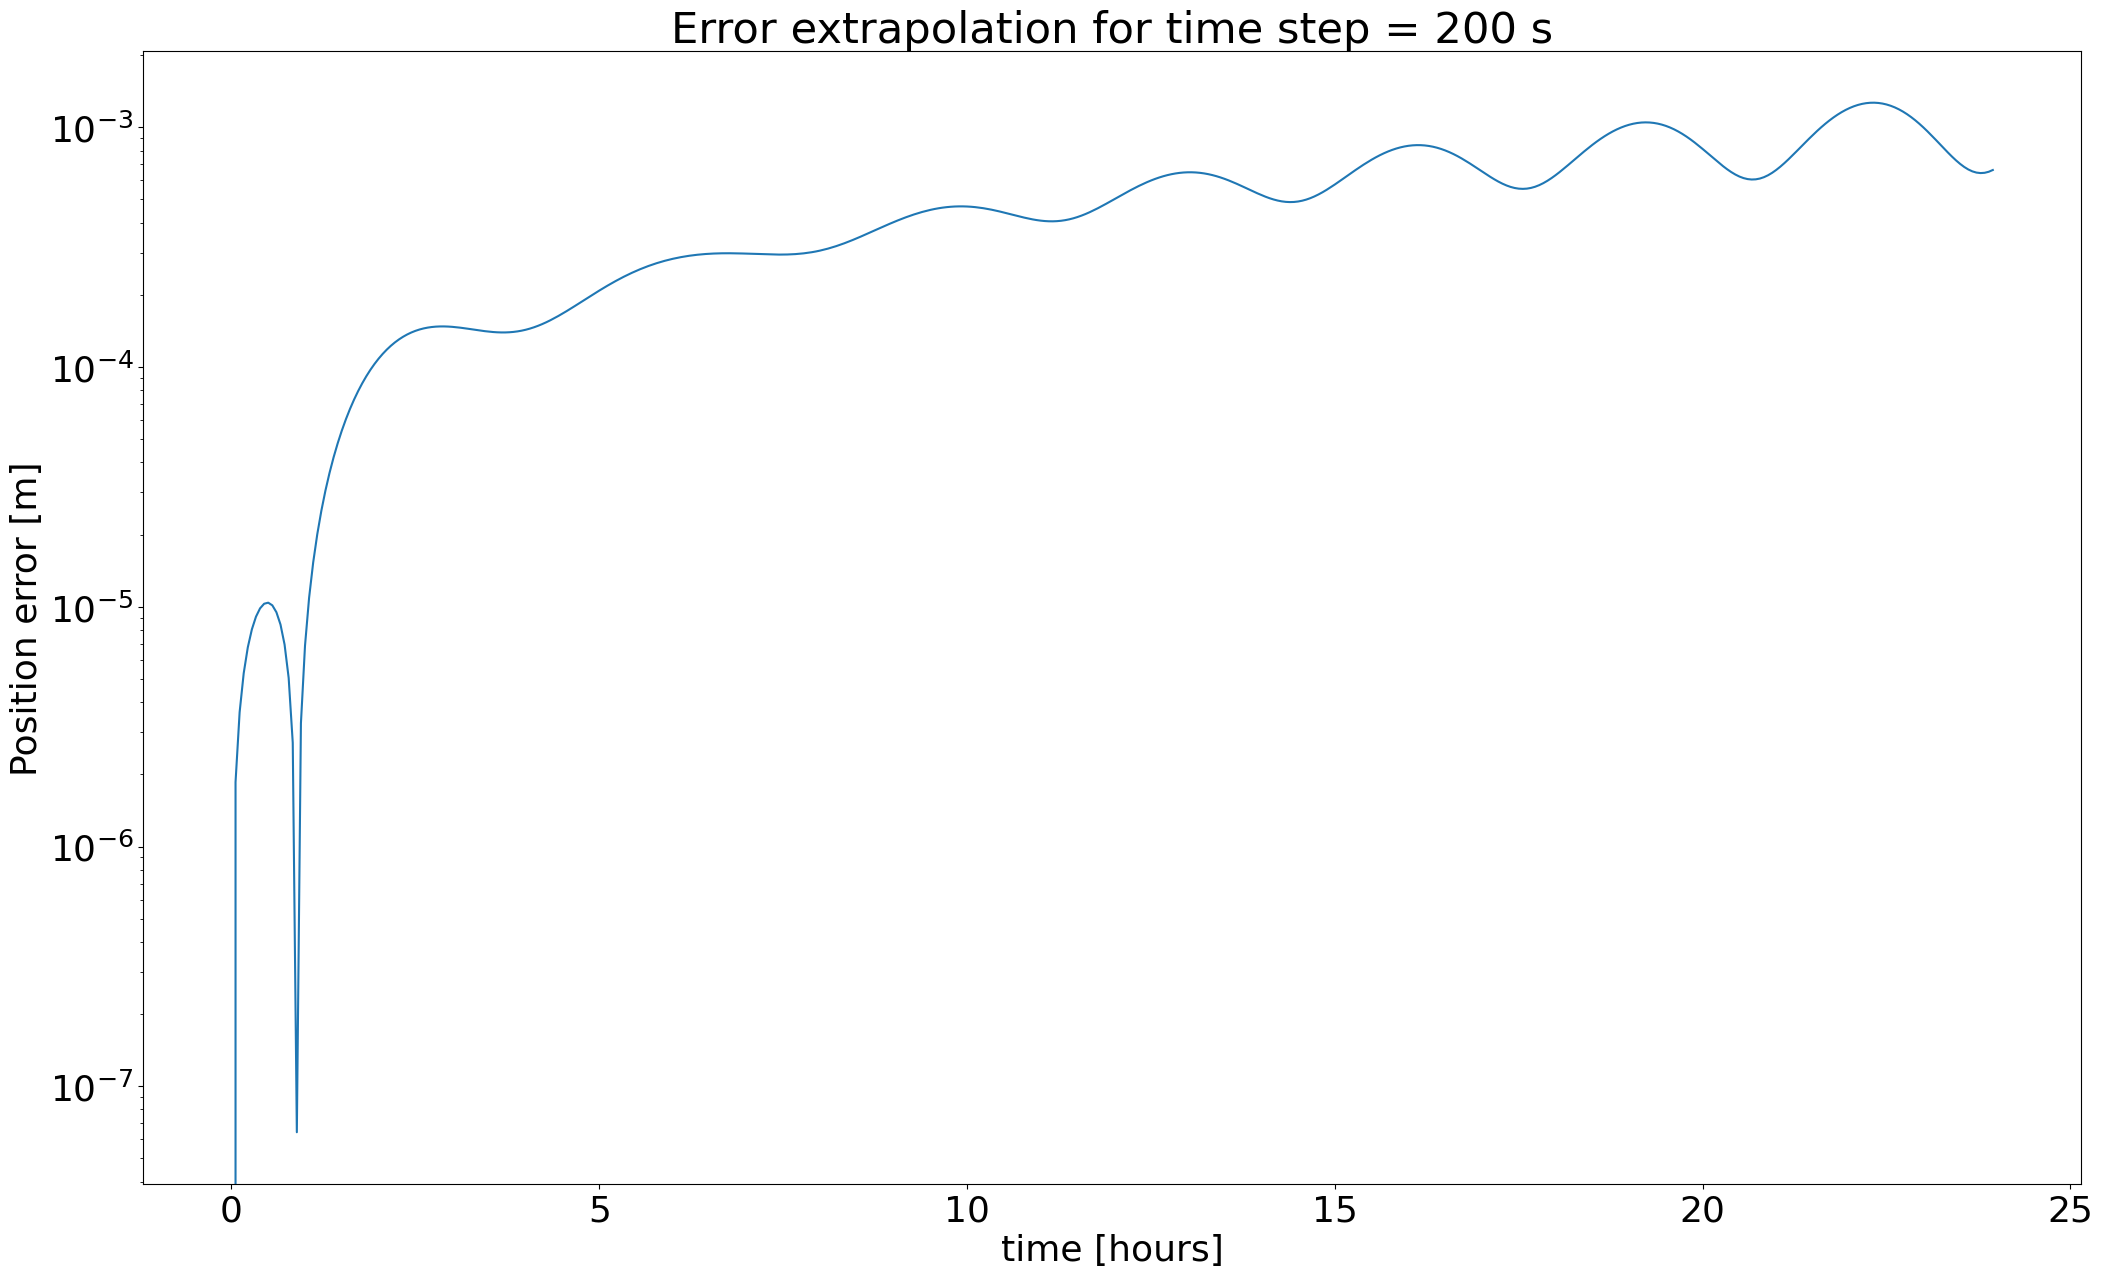

In [49]:
# Define step sizes to use (STUDENT CODE task)
#step_sizes = [25,50,100,200]
#step_sizes = np.arange(10,54,4)
step_sizes = [100, 200]
step_100 = []
step_200 = []
ts = []
# Iterate over phases
#for current_phase in range( len(central_bodies_per_phase )):
for q in range(1):    
    # Create initial state and time
    current_phase = 1
    current_phase_start_time = initial_times_per_phase[ current_phase ]
    current_phase_end_time = current_phase_start_time + propagation_times_per_phase[ current_phase ]
    
    current_central_body = central_bodies_per_phase[ current_phase ]
    central_bodies = [ current_central_body ]
    
    # Retrieve JUICE initial state
    initial_state = spice_interface.get_body_cartesian_state_at_epoch(
        target_body_name="JUICE",
        observer_body_name=current_central_body,
        reference_frame_name=global_frame_orientation,
        aberration_corrections="NONE",
        ephemeris_time=current_phase_start_time
    )
    
    # Retrieve acceleration settings
    acceleration_models = get_unperturbed_accelerations( current_central_body, bodies, current_phase)
    dependent_variables_to_save = []
    
    # Define propagator settings (STUDENT CODE task)
    bodies_to_propagate = ["JUICE"]
    propagator_settings = propagation_setup.propagator.translational(
        central_bodies,
        acceleration_models,
        bodies_to_propagate,
        initial_state,
        current_phase_end_time,
        output_variables = dependent_variables_to_save
)
    fig=plt.figure(figsize=(25,15), dpi= 100, facecolor='w', edgecolor='k')
    matplotlib.rcParams.update({'font.size': 26})
    #plt.ylabel('Posistion error [m]')
    #plt.xlabel('Time step [s]')
    #if current_phase == 0:
    #    plt.title('Maximum integration error using different step sizes rkf7(8) integrator Callisto flyby')
    #if current_phase == 1:
    #    plt.title('Maximum integration error using different step sizes rkf7(8) integrator Ganymede orbit')
    
    # Iterate over step size
    max_error = []
    for step_size in step_sizes:
        
        # Define integrator settings
        integrator_settings = get_fixed_step_size_integrator_settings(current_phase_start_time, step_size)
        
        # Propagate dynamics (STUDENT CODE task)
        dynamics_simulator = propagation_setup.SingleArcDynamicsSimulator(
                    bodies, integrator_settings, propagator_settings, True)
        state_history = dynamics_simulator.state_history
        
        # Compute difference w.r.t. analytical solution to file
        central_body_gravitational_parameter = bodies.get_body( current_central_body ).gravitational_parameter
        keplerian_solution_difference = get_difference_wrt_kepler_orbit( 
            state_history, central_body_gravitational_parameter)
        
        # Write results to files
        file_output_identifier = "Q1_step_size" + str(step_size) + "_phase_index" + str(current_phase)   
        write_propagation_results_and_analytical_solution_to_file( 
            dynamics_simulator, file_output_identifier, bodies.get_body( current_central_body ).gravitational_parameter)
        
        time = state_history.keys()
        if step_size == 100:
            for t in time:
                step_100.append(np.linalg.norm(state_history[t][:3]))
        if step_size == 200:
            for t in time:
                step_200.append(np.linalg.norm(state_history[t][:3])) 
                ts.append((t - current_phase_start_time)/3600 )
    lst = []    
    for i in range(len(step_200)-1): 
        lst.append(abs((step_200[i] - step_100[2*i])/(1-(0.5**7))))
    
    plt.plot(ts[:-1], lst)
    plt.yscale('log')
    plt.xlabel('time [hours]')
    plt.ylabel('Position error [m]')
    plt.title('Error extrapolation for time step = 200 s')
    #plt.savefig('Q5.png')
    plt.show()
        
        #time   = keplerian_solution_difference.keys()
        #time_hours = [ t / 3600 - current_phase_start_time/ 3600 for t in time]
        #error = []
        #for t in time:
        #    error.append(np.linalg.norm(keplerian_solution_difference[t][:3]))
        #plt.plot(time_hours, error, label = 'dt = '+ str(step_size) + ' s')
        #max_error.append(max(error))
        
    #plt.plot(step_sizes, max_error)
    #plt.legend()
    #plt.yscale('log')
    #plt.savefig('Q5a.png')
    #plt.show()
     
        
                    
        

Now that we have analyzed the integration error of the benchmark for the unperturbed case, we move to analyzing the integration errors of the perturbed case. This encompasses the following accelerations:

* Spherical harmonics gravity of the central body (Ganymede for GCO500, Callisto for flyby) up to and including degree 2, order 2;
* Spherical harmonics gravity of Jupiter up to and including degree 6, order 0;
* Central (point mass) gravity of the following bodies: Io, Europa, Sun, Saturn.
* Central (point mass) gravity of Ganymede (for flyby phase) or Callisto (for GCO500)
* Cannonball radiation pressure;
* Only in the case of GCO500: aerodynamic acceleration.

**For normal situations, you would use the time step $\Delta t$ determined in question 1d for your benchmark. To ensure consistency in all students' results, in what follows, use the RKF7(8) solution with $\Delta t=5$ s (for GCO500) and $\Delta t=1$ s (for the flyby) as benchmark.**

The variable step-size integration settings you will use in the following questions depends on your student number, which we write as ABCDEFG (so for student number 1244779, A=1, B=2, C=4, etc.):

* D = 0, D = 1 or D = 2: RKF7(8) integrator
* D = 3, D = 4 or D = 5: RKF5(6) integrator
* D = 6, D = 7, D = 8 or D = 9: RKF4(5) integrator
* **For all student numbers:** absolute and relative tolerance $10^{-12}$, $10^{-10}$, $10^{-8}$  and  $10^{-6}$.

Use initial step size = 10 s, maximum step size = $\infty$ (`np.infty`), minimum step size = $10^{-12}$ (note that this value has been chosen arbitrarily to represent a 'very small' value), and default settings for any other inputs not specified here.

# Question 2
### 30 points; Maximum text length: 25 lines

First, generate the following set of 5 numerical results for each phase:

* The benchmark solution (RKF7(8) fixed step size, with step size given above) for the perturbed case
* The variable step-size results, using your required integrator and tolerances and four sets of tolerances.

Using the benchmark as the "true" values (e.g. assuming them to have zero errors), plot the error as a function of time for the four tolerances, in both phases. Use an 8$th$ order Lagrange interpolator to interpolate the benchmark solution to the epochs of the variable step-size results.

**Answer the following questions:**


**a)** Does the error of the variable time-step solutions behave as you expect, both over time and over tolerance? Discuss the two phases separately. Be specific in the theoretical reason(s) for your expectations, including discussion on the dynamics of the system you are solving, properties of truncation error, and properties of rounding error.

**b)** For both phases, plot the time step $\Delta t$ as a function of time for each tolerance. Explain the physical and mathematical reasons underlying the times at which $\Delta t$ takes its maximum and minimum values, for your simulations with $10^{-10}$ tolerances. Explicitly use the governing equations of the step-size control in your argumentation. For the flyby, perform this analysis over the fill 8 hour arc. For the GCO500, perform this analysis over a single orbit. Save any relevant dependent variables to verify your hypothesis.

**c)** Generate the variable step-size numerical results for the *unperturbed* case, and use the analytical solution to determine the integration errors. Do the errors you obtain w.r.t. the analytical solution correspond (approximately) to your estimate of the error in the perturbed situation created in question 2a? Explain the reason(s) why this is (not) the case.

**d)** Based on your answer to the previous question, explain whether using the unperturbed dynamics to determine benchmark integrator settings for the perturbed case is a valid approach, or not. Provide the theoretical reasons why this is the case, explicitly using mathematical equations describing the behaviour of the integration errors, and saving and plotting relevant dependent variables to back up your answer as needed.



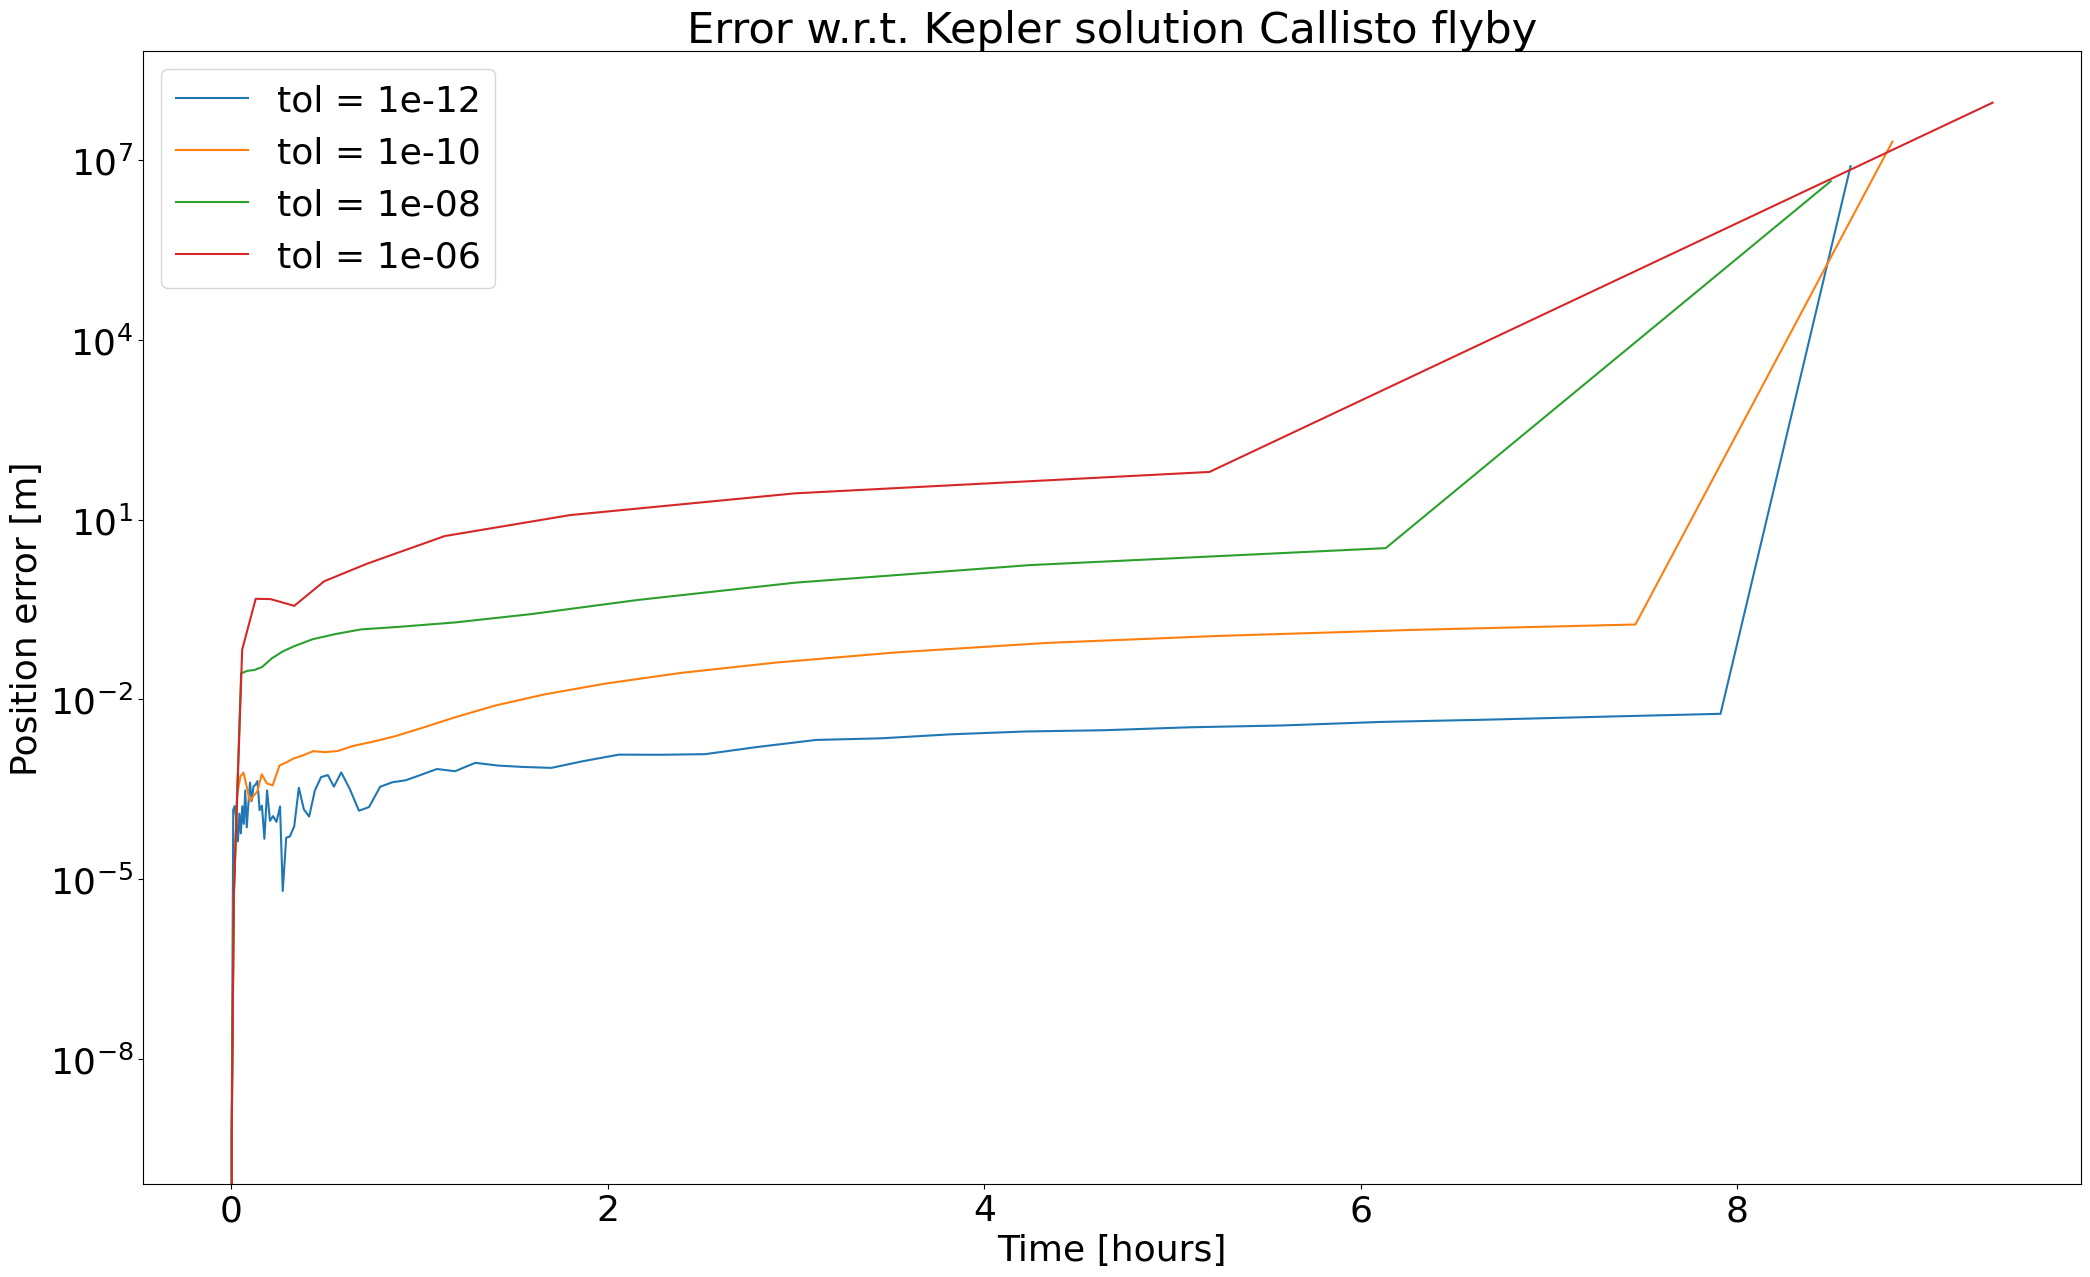

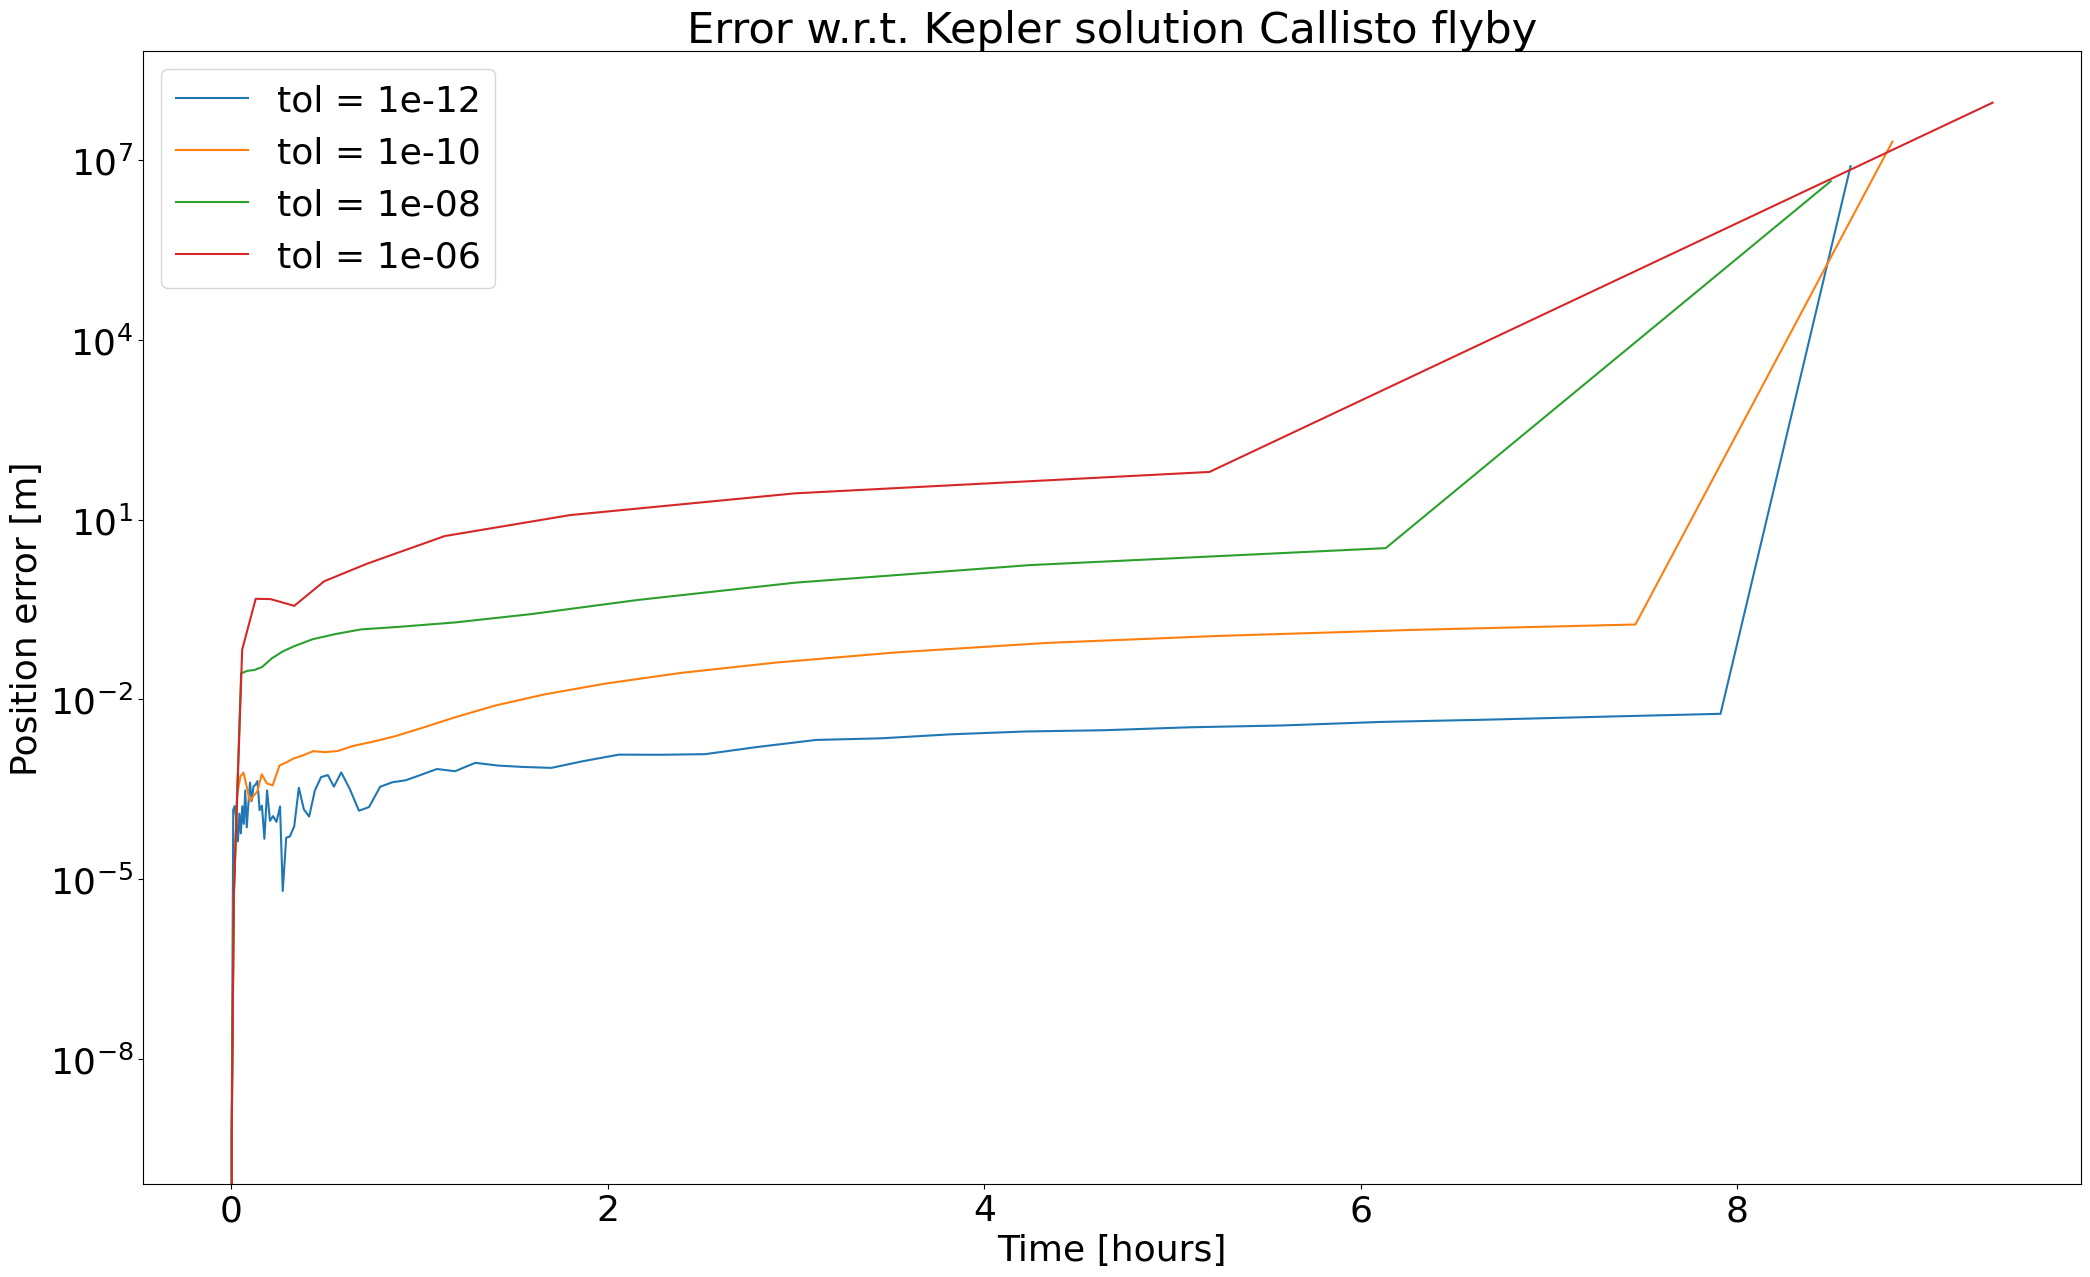

In [11]:

# Define which questions to run (question 2 only, or questions 2 and 3)
run_question_2 = True
run_question_3 = True

questions_to_run = []
if run_question_2:
    questions_to_run.append(2)

if run_question_3:
    if not run_question_2:
        raise Exception("Error, cannot run Q3 without Q2")        
    questions_to_run.append(3)

# Define list of integrator tolerances (STUDENT CODE task)
integration_tolerances = [1.0E-12, 1.0E-10, 1.0E-8, 1.0E-6]
#integration_tolerances = [1.0E-10]
# Iterate over questions

for current_question in questions_to_run:
    current_question = 3   
    # Only run flyby phase for Q3
    if current_question == 3:
        number_of_phases = 1
    else:
        number_of_phases = 2
        
    for current_phase in range( number_of_phases ):
        #current_phase = 1
        # Create initial state and time
        current_phase_start_time = initial_times_per_phase[ current_phase ]

        # For Q3, reset initial time to time of closest approach
        if current_question == 3:
            current_phase_start_time = get_closest_approach_time( )

        # Compute propagation end time    
        current_phase_end_time = current_phase_start_time + propagation_times_per_phase[ current_phase ]
        
        # STUDENT CODE task: complete lines below to 
        #  * Create unperturbed propagator settings
        #  * Create perturbed propagator settings
        #  * Create benchmark integrator settings
        #  * Propagate dynamics with benchmark settings

        # Create accelerations 
        bodies_to_propagate = ["JUICE"]
        
        current_central_body = central_bodies_per_phase[ current_phase ]
        central_bodies = [ current_central_body ]
        if current_phase == 0:
            acceleration_models_perturbed = get_perturbed_accelerations_callisto( central_bodies, bodies)
        
        if current_phase == 1:
            acceleration_models_perturbed = get_perturbed_accelerations_ganymede( central_bodies, bodies)

        # Define perturbed propagator settings
        dependent_variables_to_save = [propagation_setup.dependent_variable.total_acceleration("JUICE"),
                                       propagation_setup.dependent_variable.relative_position("JUICE","Ganymede"),
                                       propagation_setup.dependent_variable.keplerian_state("JUICE", "Ganymede")]
        
        initial_state = spice_interface.get_body_cartesian_state_at_epoch(
            target_body_name="JUICE",
            observer_body_name=current_central_body,
            reference_frame_name=global_frame_orientation,
            aberration_corrections="NONE",
            ephemeris_time=current_phase_start_time
        )
        perturbed_propagator_settings = propagation_setup.propagator.translational(
            central_bodies,
            acceleration_models_perturbed,
            bodies_to_propagate,
            initial_state,
            current_phase_end_time,
            output_variables = dependent_variables_to_save
        )

        # Create accelerations for unperturbed case
        acceleration_models_unperturbed = get_unperturbed_accelerations( central_bodies, bodies, current_phase)

        # Define unperturbed propagator settings
        unperturbed_propagator_settings = propagation_setup.propagator.translational(
            central_bodies,
            acceleration_models_unperturbed,
            bodies_to_propagate,
            initial_state,
            current_phase_end_time
        )

        # Define integrator settings for benchmark
        if current_phase == 0:
            benchmark_time_step = 1.0
        else:
            benchmark_time_step = 5.0
            
        benchmark_coefficient_set = propagation_setup.integrator.RKCoefficientSets.rkf_78
        
    
        benchmark_integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size_scalar_tolerances(
            current_phase_start_time,
            benchmark_time_step,
            benchmark_coefficient_set,
            benchmark_time_step,
            benchmark_time_step,
            np.infty,
            np.infty
        )
        
        # Propagate benchmark dynamics
        benchmark_dynamics_simulator = propagation_setup.SingleArcDynamicsSimulator(
                    bodies, benchmark_integrator_settings, perturbed_propagator_settings, True)
        bench_state_history = benchmark_dynamics_simulator.state_history
       
        # Create interpolator for benchmark results
        interpolator_settings = interpolators.lagrange_interpolation( 8 )
        benchmark_interpolator = interpolators.create_one_dimensional_interpolator( 
            benchmark_dynamics_simulator.state_history, interpolator_settings )
    
        
        
        # Perform integration of perturbed dynamics with different tolerances
        fig=plt.figure(figsize=(25,15), dpi= 100, facecolor='w', edgecolor='k')
        matplotlib.rcParams.update({'font.size': 26})
        plt.ylabel('Position error [m]')
        plt.xlabel('Time [hours]')
        if current_phase == 0:
            plt.title('Error w.r.t. Kepler solution Callisto flyby')
        if current_phase == 1:
            plt.title('Error w.r.t. Kepler solution Ganymede orbit' )
        
        
        for current_tolerance in integration_tolerances:
            
            # STUDENT CODE task (create integrator settings)
            initial_time_step = 10.0
            minimum_step_size = 1.0E-16
            maximum_step_size = np.inf
            
            # Retrieve coefficient set
            coefficient_set = propagation_setup.integrator.RKCoefficientSets.rkf_56
            
            # Create variable step-size integrator settings
            
            integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size_scalar_tolerances(
                current_phase_start_time,
                initial_time_step,
                coefficient_set,
                minimum_step_size,
                maximum_step_size,
                current_tolerance,
                current_tolerance
        ) 
            
            # Define output file name
            file_output_identifier = "Q" + str(current_question) + "tolerance-index" + \
                                        str(integration_tolerances.index(current_tolerance)) + \
                                        "_phase-index" + str(current_phase)
            
            # Propagate perturbed dynamics and compare to benchmark (STUDENT CODE task)
            perturbed_dynamics_simulator = propagation_setup.SingleArcDynamicsSimulator(
                    bodies, integrator_settings, perturbed_propagator_settings, True)
            
            perturbed_state_history = perturbed_dynamics_simulator.state_history
            dependent_variables     = perturbed_dynamics_simulator.dependent_variable_history
            
            #write_propagation_results_and_benchmark_difference_to_file( 
            #    perturbed_dynamics_simulator, file_output_identifier, benchmark_interpolator)            
            
            # Propagate unperturbed dynamics and compare to Kepler orbit (STUDENT CODE task)
            
            unperturbed_dynamics_simulator = propagation_setup.SingleArcDynamicsSimulator(
                    bodies, integrator_settings, unperturbed_propagator_settings, True) 
            
            unperturbed_state_history = unperturbed_dynamics_simulator.state_history
            
            write_propagation_results_and_analytical_solution_to_file( 
                unperturbed_dynamics_simulator, file_output_identifier + "_unperturbed",
                                                                     bodies.get_body( current_central_body ).gravitational_parameter)
           
            central_body_gravitational_parameter = body_settings.get( current_central_body ).gravity_field_settings.get_gravitational_parameter( )
            keplerian_solution_difference = get_difference_wrt_kepler_orbit( 
                unperturbed_state_history, central_body_gravitational_parameter)
            
            bench_diff = []
            kepler_diff = []
            benchmark_difference = get_difference_wrt_benchmarks( perturbed_state_history , benchmark_interpolator )
            time_bench = benchmark_difference.keys()
            time_bench_hours = [ t / 3600 - current_phase_start_time/ 3600 for t in time_bench]
            for t in time_bench:
                bench_diff.append(np.linalg.norm(benchmark_difference[t][:3]))
            
            #kepler_difference = get_difference_wrt_kepler_orbit( unperturbed_state_history, central_body_gravitational_parameter )
            ##time_kepler = kepler_difference.keys()
            #time_kepler_hours = [ t / 3600 - current_phase_start_time/ 3600 for t in time_kepler]
            #for t in time_kepler:
            #    kepler_diff.append(np.linalg.norm(kepler_difference[t][:3]))
            
            #time_pert = perturbed_state_history.keys()
            #time_pert_hours = [ t / 3600 - current_phase_start_time/ 3600 for t in time_pert]
            #times_steps = []
            #acc = []
            #t_0 = current_phase_start_time
            #t = []
            #for ts in time_pert:
            #    t.append(ts)
            #    t_i = ts
            #    times_steps.append(t_i - t_0)
            #    t_0 = t_i
            #    acc.append(np.linalg.norm(dependent_variables[ts][3:6]))
            
            #index = acc.index(min(acc))
            #print(t[index])
            #avg_acc = sum(acc)/len(acc)
            #norm_acc = acc / avg_acc
            
            #plt.plot(time_pert_hours[110:250], times_steps[110:250], label = 'Time step')
            #plt.plot(time_pert_hours[110:250], acc[110:250], label = 'Total acceleration')
            #plt.plot(time_pert_hours[110:250], norm_acc[110:250], label = 'Total acceleration')

                

                
            plt.plot(time_bench_hours, bench_diff, label = 'tol = ' + str(current_tolerance))
            #plt.plot(time_kepler_hours[:], kepler_diff[:], label = 'tol = ' + str(current_tolerance))
            
        plt.yscale('log')
        plt.legend()
        plt.savefig('Q3a.png')
        plt.show()

                
                
    

# Question 3
### 15 points; Maximum text length: 8 lines

For this question, consider the analysis of the **flyby trajectory only**. Instead of setting the initial time $t_{0}$ to the value you are provided, set the initial time as the closest approach, and propagate forward in time by 8 hours. 

*Because this question is very similar in code as Q2, the code of Q2 will be re-used. For this question, prepare the* `get_closest_approach_time()` *function, and re-run the code of Q2 with* `run_question3 = True` *AND* `run_question2 = True`. 

**Answer the following questions:**


**a)** Compute, using the `get_closest_approach_time` function in the Python code (and the benchmark integrator settings), the closest approach to Callisto to an accuracy of 5 s. Give the value in your report as $t_{c}-t_{0} = ... $.

**b)** Propagate the orbit forward in time from $t_{c}$. Use the same final propagation time, and 5 integrator settings (1 benchmark, 4 variable time-step), as in question 2. Compare the integration errors (computed w.r.t. your benchmark computed here) with those you obtain in question 2. Explain the reasons for the difference in the error behaviour (in time $t$) compared to your results in question 2

# Question 4
### 20 points; Maximum text length: 10 lines

We will now shift our analysis to assessing the **local** truncation error made during a single step of the integration, **for the GCO500 phase**. Using a fixed time step of 300 s, and the RKF7(8) integrator, perform 20 separate *single* steps of the integration of the **unperturbed** orbit, with initial time $\tilde{t}_{0}$ set as:

\begin{align}
\tilde{t}_{0}={t}_{0}+i\cdot 600
\end{align}

with all times in seconds, and $i=0...19$.

**Answer the following questions:**


**a)** For each of your 20 single integration steps, compute the LTE incurred over this single time step, and determine the error constant $\mathbf{K}(t)$, assuming:

\begin{align}
\boldsymbol{\epsilon_{_{\text{LTE}}}}(t)=\mathbf{K}(t)\Delta t^{p+1}
\end{align}

where $p$ is the order of the GTE of the integrator. Plot  $||\mathbf{K}_{\mathbf{r}}(t)||$ as a function of time, with $\mathbf{K}_{\mathbf{r}}$ the first three entries of the vector $\mathbf{K}$.

**b)** For each step, expand the analytical solution for the Cartesian state as a Taylor series in $t$, about $t=\tilde{t}_{0}$ (assume eccentricity $e=0$), and derive and plot the theoretical value of $||\mathbf{K}_{\mathbf{r}}(t)||$ for each point along the orbit.

**c)** Redo the 20 propagations, but now using an Euler integrator with a time step of 10 s. Using the method of the previous question, derive the theoretical value of $\mathbf{K}(t)$ for each point along the orbit for the Euler integrator. Plot the results the theoretical and numerical values (computed w.r.t. the benchmark) of $||\mathbf{K}_{\mathbf{r}}(t)||$ as a function of time.

**d)** Do the values of $\mathbf{K}(t)$ computed analytically correspond to the value you find numerically, and why (not)? In your answer, discuss any significant differences you observe between the validity of the analytical result for the Euler and RKF7(8) results.




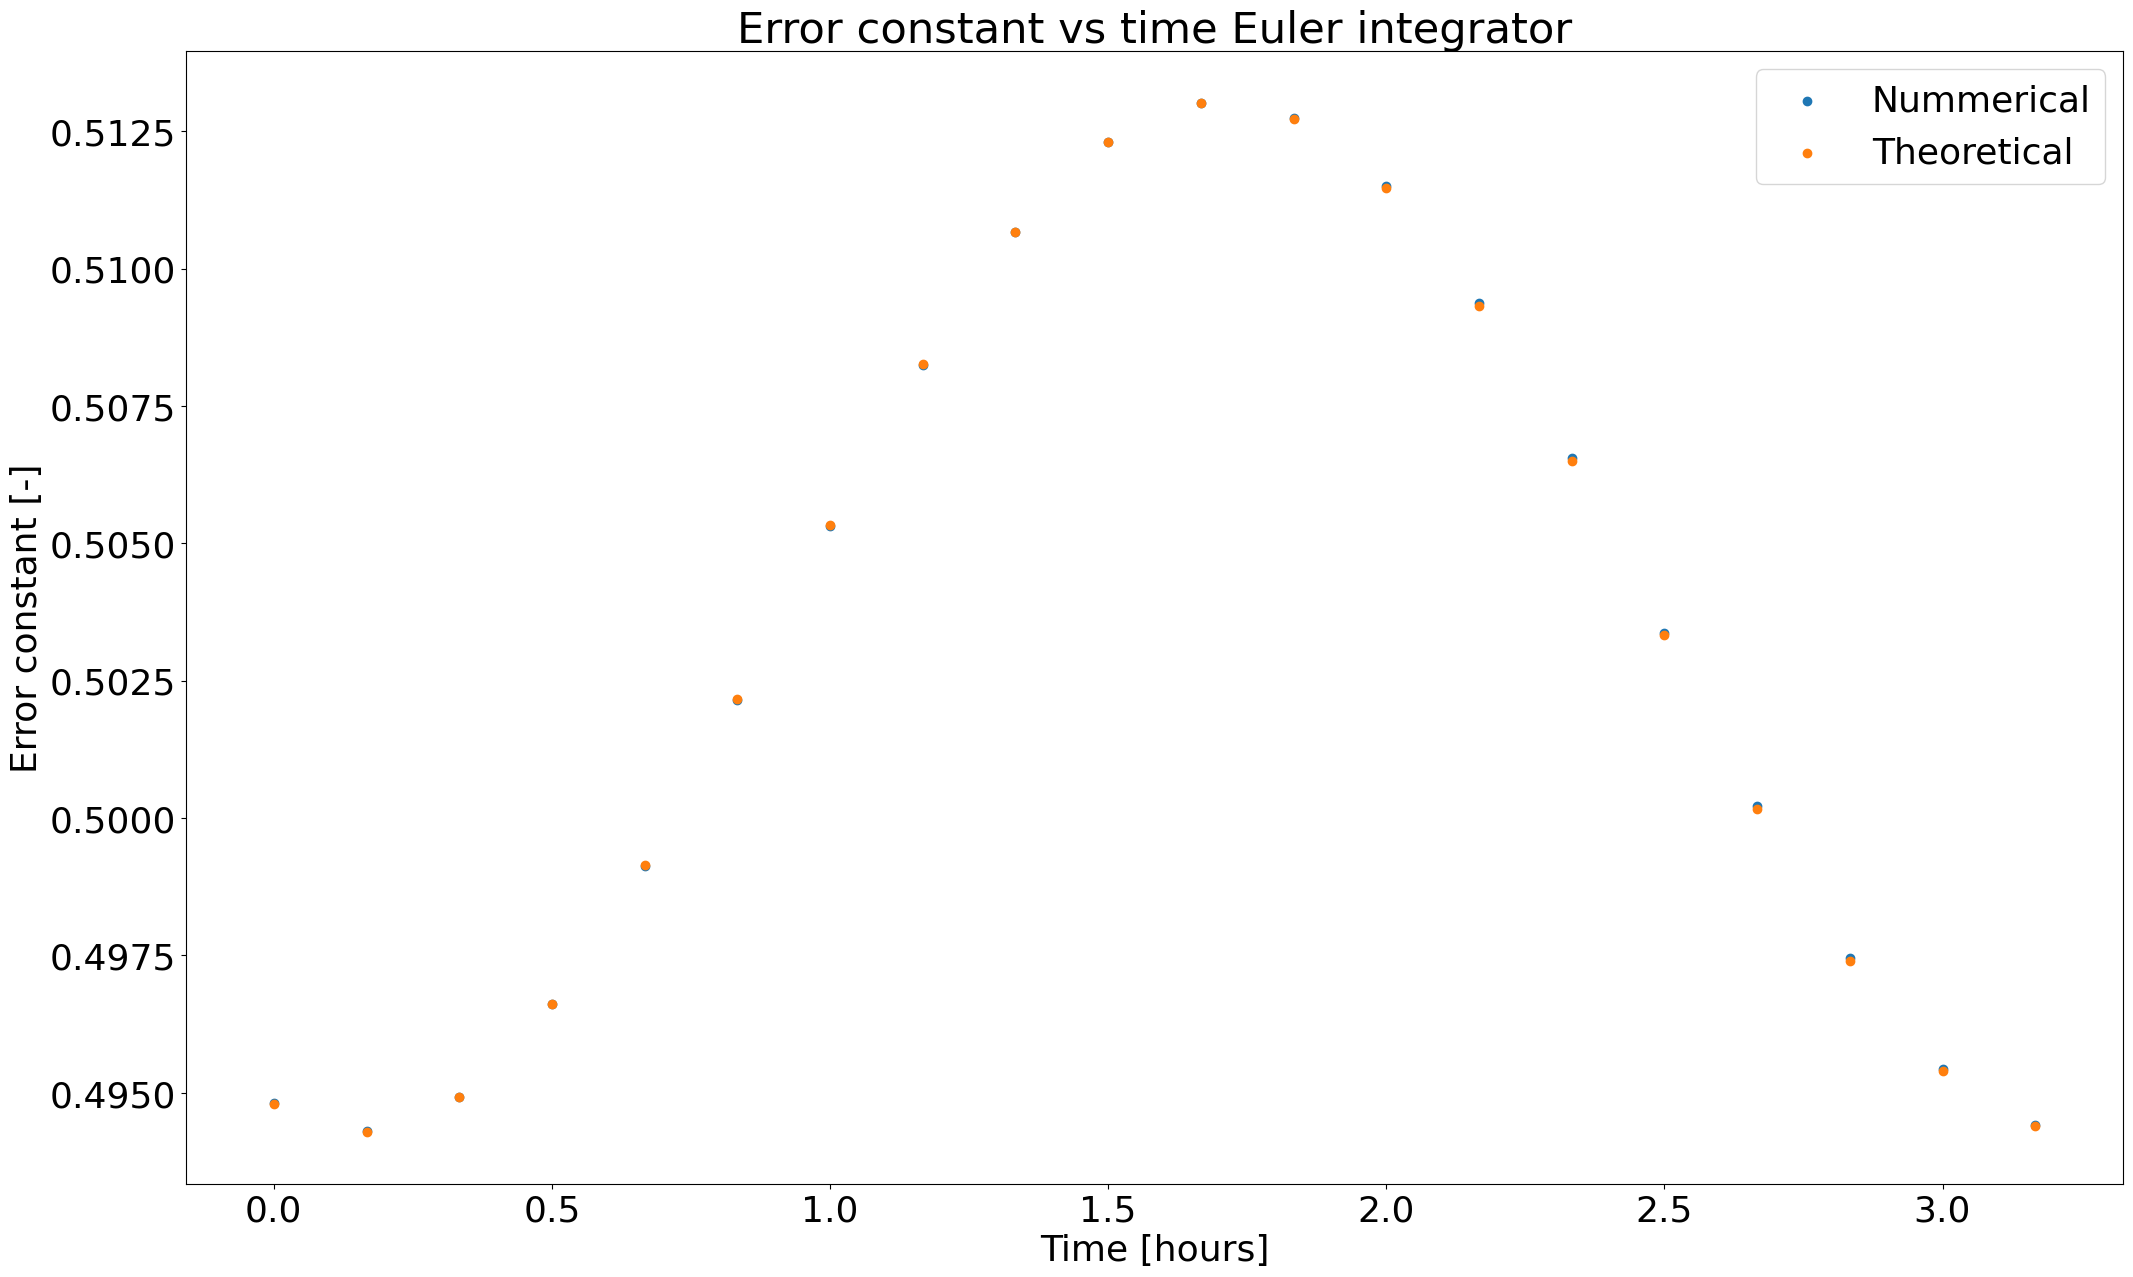

In [42]:
# Define settings for orbit only, unperturbed only
current_phase = 1
central_body = "Ganymede"
central_bodies = [ central_body ]
current_phase_start_time = initial_times_per_phase[current_phase]
acceleration_models = get_unperturbed_accelerations( central_body, bodies, current_phase)

step_per_run = 600.0
K_r_i = []
K_r_ii = []
t_i = []
t_ii = []
w_i  = []
# Perform 20 individual steps
for i in range(20):
    
    # Compute initial time of current step (STUDENT CODE task)
    current_start_time = current_phase_start_time + (step_per_run * i)
    
    # Compute initial state of current step (STUDENT CODE task)
    initial_state = spice_interface.get_body_cartesian_state_at_epoch(
            target_body_name="JUICE",
            observer_body_name=central_body,
            reference_frame_name=global_frame_orientation,
            aberration_corrections="NONE",
            ephemeris_time=current_start_time
        )
    
    '''
    RKF
    '''
    
    # Define propagator settings, terminate after 300 s.
    time_step = 300.0
    termination_time = current_start_time + time_step    
    termination_settings = propagation_setup.propagator.time_termination( termination_time, True )
    propagator_settings = propagation_setup.propagator.translational(
            central_bodies,
            acceleration_models,
            bodies_to_integrate,
            initial_state,
            termination_settings )
    
    # Get fixed step RKF78 integrator settings (STUDENT CODE task)
    coefficient_set = propagation_setup.integrator.RKCoefficientSets.rkf_78
    integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size_scalar_tolerances(
        current_start_time,
        time_step,
        coefficient_set,
        time_step,
        time_step,
        np.infty,
        np.infty
    )


    # Propagate Dynamics (STUDENT CODE task)
    dynamics_simulator = propagation_setup.SingleArcDynamicsSimulator(
                    bodies, integrator_settings, propagator_settings, True) 
    central_body_gravitational_parameter = body_settings.get( central_body ).gravity_field_settings.get_gravitational_parameter( )
    state_history = dynamics_simulator.state_history
    #w = np.sqrt(central_body_gravitational_parameter / (np.linalg.norm(state_history[termination_time][:3])**3))
    #w_i.append(np.linalg.norm((state_history[termination_time][:3]) * w **8)/np.math.factorial(8))
    
    # Compute difference w.r.t. analytical solution (STUDENT CODE task, use helper functions)
    #central_body_gravitational_parameter = body_settings.get( central_body ).gravity_field_settings.get_gravitational_parameter( )
    local_truncation_error = np.linalg.norm(get_difference_wrt_kepler_orbit( state_history, central_body_gravitational_parameter )[termination_time][:3])
    K_r_i.append( local_truncation_error / (time_step**8))
    t_i.append((current_start_time - current_phase_start_time)/3600)
    
    '''
    Euler
    '''
    
    # Define propagator settings, terminate after 10 s.
    time_step = 10.0
    termination_time = current_start_time + time_step    
    termination_settings = propagation_setup.propagator.time_termination( termination_time, True )
    propagator_settings = propagation_setup.propagator.translational(
            central_bodies,
            acceleration_models,
            bodies_to_integrate,
            initial_state,
            termination_settings )
    
    # Get fixed step Euler integrator settings (STUDENT CODE task)
    integrator_settings = propagation_setup.integrator.euler(
            current_start_time,
            time_step)
    
    # Propagate Dynamics (STUDENT CODE task)
    dynamics_simulator = propagation_setup.SingleArcDynamicsSimulator(
                    bodies, integrator_settings, propagator_settings, True) 
    state_history = dynamics_simulator.state_history
    
    w = np.sqrt(central_body_gravitational_parameter / (np.linalg.norm(state_history[termination_time][:3])**3))
    w_i.append(np.linalg.norm((state_history[termination_time][:3]) * w **2)/np.math.factorial(2))
    
    # Compute difference w.r.t. analytical solution (STUDENT CODE task, use helper functions)
    local_truncation_error = np.linalg.norm(get_difference_wrt_kepler_orbit( state_history, central_body_gravitational_parameter )[termination_time][:3])
    K_r_ii.append( local_truncation_error / (time_step**2))
    
    
fig=plt.figure(figsize=(25,15), dpi= 100, facecolor='w', edgecolor='k')
matplotlib.rcParams.update({'font.size': 26})
plt.scatter(t_i, K_r_ii, label = 'Nummerical')
plt.scatter(t_i, w_i, label = 'Theoretical')
plt.legend()
#plt.yscale('log')
plt.ylabel('Error constant [-]')
plt.xlabel('Time [hours]')
plt.title('Error constant vs time Euler integrator')
plt.savefig('Q4b.png')
plt.show()



# Question 5
### 15 points; Maximum text length: 15 lines; Maximum figure length: 1 page

For this question, no new Tudat simulations need to be run. Instead, you will reuse the results from question 1. Answer the following questions:


**a)** Using the results with fixed step size $\Delta t=$100 and 200 s, for GCO500, use error extrapolation to estimate the numerical integration error of your $\Delta t=$200 s integration. Plot the error as a function of time.

**b)** Explain mathematically whether you think that this error extrapolation could, in general, be robustly used to determine the error of the smaller-step integration (*e.g* use the $\Delta t=100$ s and $\Delta t=200$ s results as input to the error extrapolation to estimate the error for the  $\Delta t=100$ s  results). In your discussion, explicitly use the assumptions that go into the formulation of the error extrapolation.

# Submission and reporting instructions


**Reporting instructions - formulating equations of motion**

When asked to explicitly write out one or more accelerations

<ul>
    <li> Follow the notation from the lecture notes </li>
    <li> Use the following indices: $S$ for Sun, $E$, $V$ and $M$ for Earth, Venus and Mars, respectively, and $p$ for the spacecraft. </li>
    <li> Use a comma to separate indices as you see fit (spacecraft position w.r.t. the Sun can be written as $\mathbf{r}_{S,p}$ or $\mathbf{r}_{Sp}$). </li>
    <li> There is no need to specify the frame orientation of any of the vectors. All are assumed to be in a frame with inertial orientation. </li>
    <li> When denoting separate accelerations, always denote the body $B$ exerting, and body $A$ undergoing, the acceleration with $\mathbf{a}_{_{BA}}$. </li>
    <li> When writing out a single acceleration in terms of positions $\mathbf{r}$, always first write the total relative positions $\mathbf{r}_{_{CD}}$ as used by the acceleration model. Expand the positions further as you see fit in next steps. </li>
    <li> When writing a position $\mathbf{r}_{_{CD}}$ that is partly retrieved from the environment (if any), and  where part of the vector is numerically propagated, split the separate contributions (in a second step after the previous point). For instance, if  $\mathbf{r}_{_{ED}}$ is propagated, and $\mathbf{r}_{_{CD}}$ is used in the acceleration, write $\mathbf{r}_{_{CD}}=\mathbf{r}_{_{CE}}+\mathbf{r}_{_{ED}}$. </li>
</ul>

### Reporting instructions - change in position

When asked to plot/compute the change in total position between two simulation results $\mathbf{r}_{1}(t)$ and $\mathbf{r}_{2}(t)$. The change in total position is to be computed as $||\Delta \mathbf{r}(t)||= ||\mathbf{r}_{2}(t)-\mathbf{r}_{1}(t)||$

### Reporting instructions - figures

When using figures, take the following guidelines into account:

<ul>
    <li> Any text (legend, axis labels etc.) should be sufficiently large so as to be legible when printed on A4 paper. </li>
    <li>Each curve should be distinguishable in your plots. </li>
    <li>Adjust the scale (e.g. linear vs. logarithmic) of your plots as needed to interpret your data.</li>
    <li>Make efficient use of space for graphs and plots. Whenever possible and legible: plot multiple curves (e.g. for different runs and/or elements) in a single figure. </li>
    <li>All figures must be complete (including axis labels, legend, caption, etc.)</li>
</ul>

Points will be deducted for unreadable figures, or figures that do not clearly show information that you refer to in your discussion.

### Reporting instructions - cover page

The cover page of each report **must contain**:

<ul>
    <li> A link to the private Github repository containing the source code and output files (see below). </li> 
    <li> The names of any people with whom you cooperated (if any) </li>
    <li> The time spent per question </li>
</ul>

If any of these points are not present on your cover page, points will be deducted.


### Reporting instructions - general

Follow the provided limitations on the length of the text that you use (this excludes figures, tables and equations). Answers longer than the imposed limit will not be read beyond this limitation. Example: if the imposed limitation is 10 lines, and you write 15, we will grade the answer based **only** on the first 10 lines.

You are free to work together with your fellow students, but are required to write your own code and report. Copying/pasting from each others report/code is not accepted, and can lead to the case being referred to the Faculty Board of Examiners.

### Support instructions

In case of any questions, there are a number of options for support:

<ul>
    <li> For issues with the installation, unit tests, or the general use of Tudat, please post an issue on Github. When posting an issue, first browse through existing issues. If your problem is raised in an open issue, post in {that} issue instead of opening a new one. Note the operating system you are using. </li>
    <li> In case of questions specific to the assignments, use the Brightspace forum. As with Github, go through existing posts before opening a new one. Do no publicly post your code, or other information that provides direct answers to the questions. </li>
    <li> In-person support and Q$\&$A is also available during working lectures and open office hours. See Brightspace calendar for time and location. </li>
</ul>

See Brightspace (Course Information $\rightarrow$ Staff and Support) for details on what to prepare when asking for support.

### Submission instructions

You will not be graded on your coding style. Submission of the reports and output files is to be done through Brightspace. **Deadline for submission is January 31 2020 23:59 CET** and can also be found on Brightspace. For late submissions, 1 point (out of a total of 10) will be subtracted {per day}. So, when handing in the report $x$ days late, $\lceil{x}\rceil$ points will be deducted. *If* you have $g$ grace days left: when handing in the report $x$ days late, $\lceil{x-g}\rceil$ points will be deducted.

Submission of your final code and results files will be done through Github. Ensure that **you only commit to a private repository**. Instructions on pushing code to Github can be found in:

https://tudat-space.readthedocs.io/en/latest/_src_use_of_tools/github.html

See below for the exact files and filenames to submit:

## *Failure to comply exactly with the requirements for file contents and naming set out below will result in point deductions.*



Instructions on how to commit code to your repository is given at https://tudat-space.readthedocs.io/en/latest/_src_use_of_tools/github.html. In addition to the report, for this assignment you will  submit:


* This notebook (which can be run directly without modifications to reproduce your results). Commit and push this file to your private GitHub repository (in the $\texttt{Assignment3/}$ directory).
        
## *Failure to comply exactly with the requirements for file contents and naming set out below will result in point deductions.*